In [1]:
import warnings
warnings.filterwarnings("ignore",
                        category=FutureWarning)
warnings.filterwarnings("ignore",
                        category=UserWarning)


# tensorflow backend
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
#environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
# vae stuff
from chemvae.vae_utils import VAEUtils
from chemvae import mol_utils as mu
# import scientific py
import numpy as np
import pandas as pd
# rdkit stuff
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


In [2]:
TEST_MOLS = ["Cc1ccc(S2(=O)=NC(=O)Nc3ccccc32)cc1",
             "CN(Cc1ccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C",
             "COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1"]
model = VAEUtils(directory='../models/zinc_properties')

From /home/dmitry/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1210: calling reduce_prod (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
From /home/dmitry/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1192: calling reduce_sum (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
From /home/dmitry/miniconda3/envs/chemvae/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1156: calling reduce_max (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


Using standarized functions? True
Standarization: estimating mu and std values ...done!


## Encoding-Decoding

In [3]:
def enc_dec_smiles(vae, smiles, max_tries=100):
    smiles_1 = mu.canon_smiles('CSCC(=O)NNC(=O)c1c(C)oc(C)c1C')

    X_1 = vae.smiles_to_hot(smiles_1,canonize_smiles=True)
    for _ in range(max_tries):
        z_1 = vae.encode(X_1)
        X_r = vae.decode(z_1)
        if (vae.hot_to_smiles(X_r, strip=True)[0] == smiles_1):
            print('{:20s} : {}'.format('Input',smiles_1))
            print('{:20s} : {}'.format('Reconstruction',vae.hot_to_smiles(X_r,strip=True)[0]))
            print('{:20s} : {} with norm {:.3f}\n'.format('Z representation',z_1.shape, np.linalg.norm(z_1)))
            return z_1


def predict_props(vae, z):
    print('Properties (qed,SAS,logP):')
    y_1 = vae.predict_prop_Z(z)[0]
    print(y_1, end="\n\n")

In [4]:
zs = [enc_dec_smiles(model, mol) for mol in TEST_MOLS]

Input                : CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
Reconstruction       : CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
Z representation     : (1, 196) with norm 10.685

Input                : CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
Reconstruction       : CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
Z representation     : (1, 196) with norm 10.685

Input                : CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
Reconstruction       : CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
Z representation     : (1, 196) with norm 10.685



## Property prediction

Предсказываемые свойства:

qed: Qualitative Estimate of Drug-likeness, насколько молекула "походит" на лекарстеннную.

SAS: synthetic accessibility score, оценка, насколько легко синтезировать молекулу.

logP: water-octanal partition coefficient, мера липофильности молекулы, позволяет оценить растворимость.

In [5]:
_ = [predict_props(model, z) for z in zs]

Properties (qed,SAS,logP):
[0.7728677 2.433176  0.9558563]

Properties (qed,SAS,logP):
[0.7728677 2.433176  0.9558563]

Properties (qed,SAS,logP):
[0.7728677 2.433176  0.9558563]



## Generation from latent space

In [6]:
def generate_from_latent(model, z, decode_attempts=100):
    noise=5.0
    print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
    df = model.z_to_smiles(z,
                           decode_attempts=decode_attempts,
                           noise_norm=noise)
    print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
    print('SMILES\n',df.smiles)
    display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
    return df

Searching molecules randomly sampled from 5.00 std (z-distance) from the point
Found 13 unique mols, out of 76
SMILES
 0     CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
1     CSC(C=O)NNC(=O)c1c(C)oc(C)c1C
2     CSCC(=O)NC(C=O)c1c(C)oc(C)c1C
3     COCC(=O)NC(C=O)c1c(C)oc(C)c1C
4     CSCC(=O)NCC(=O)c1c(C)oc(C)c1C
5     COC(C=O)NNC(=O)c1c(C)oc(C)c1C
6     COCC(=O)NCC(=O)c1c(C)oc(C)c1C
7     CSC(=O)NCNC(=O)c1c(C)oc(C)c1C
8     CSC(C=O)NCC(=O)c1c(C)oc(C)c1C
9     COC(C=O)NCC(=O)c1c(C)oc(C)c1C
10    COC(N=O)NCC(=O)c1c(C)oc(C)c1C
11    CSC(C=O)N/C(=O)c1c(C)oc(C)c1C
12    ClCC(=O)NNC(=O)c1c(C)oc(C)c1C
Name: smiles, dtype: object


RDKit ERROR: [23:45:04] non-ring atom 8 marked aromatic
RDKit ERROR: [23:45:04] Can't kekulize mol.  Unkekulized atoms: 8 9 10 13 15
RDKit ERROR: 
RDKit ERROR: [23:45:04] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 15
RDKit ERROR: 
RDKit ERROR: [23:45:04] non-ring atom 8 marked aromatic
RDKit ERROR: [23:45:04] non-ring atom 8 marked aromatic
RDKit ERROR: [23:45:04] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 15
RDKit ERROR: 
RDKit ERROR: [23:45:04] SMILES Parse Error: syntax error while parsing: CSC@(=O)NCC(=O)c1c(C)oc(C)c1C
RDKit ERROR: [23:45:04] SMILES Parse Error: Failed parsing SMILES 'CSC@(=O)NCC(=O)c1c(C)oc(C)c1C' for input: 'CSC@(=O)NCC(=O)c1c(C)oc(C)c1C'
RDKit ERROR: [23:45:04] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 15
RDKit ERROR: 


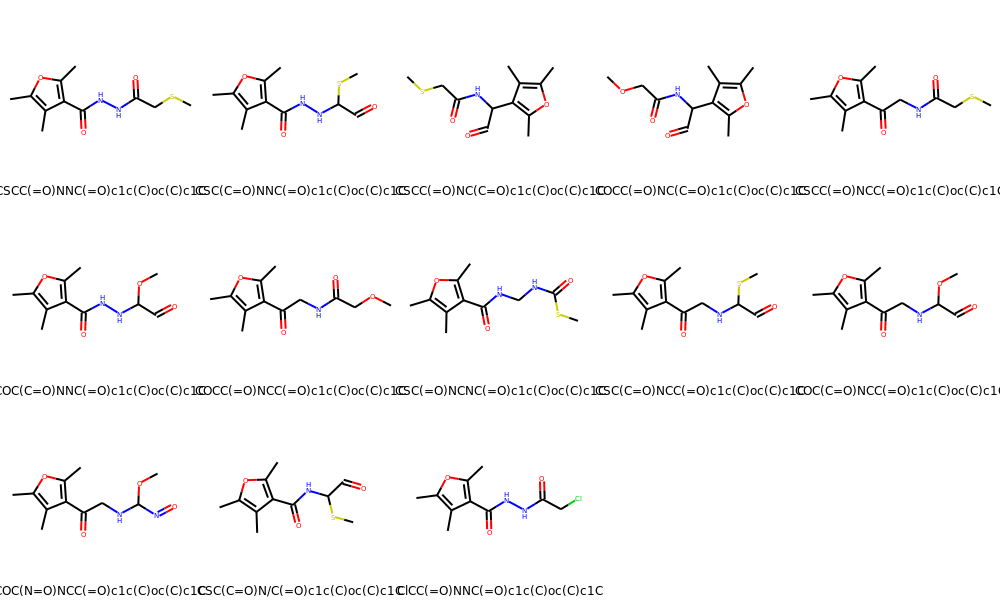

In [8]:
_ = generate_from_latent(model, zs[0])

Searching molecules randomly sampled from 5.00 std (z-distance) from the point
Found 7 unique mols, out of 78
SMILES
 0    CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
1    CSC(C=O)NNC(=O)c1c(C)oc(C)c1C
2    CSCC(=O)NC(C=O)c1c(C)oc(C)c1C
3    CSCC(=O)NCC(=O)c1c(C)oc(C)c1C
4    CSC(C=O)NCC(=O)c1c(C)oc(C)c1C
5    COC(C=O)NCC(=O)c1c(C)oc(C)c1C
6    ClC(C=O)NNC(=O)c1c(C)oc(C)c1C
Name: smiles, dtype: object


RDKit ERROR: [23:45:07] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [23:45:07] Can't kekulize mol.  Unkekulized atoms: 9 10 12 13 15
RDKit ERROR: 
RDKit ERROR: [23:45:07] SMILES Parse Error: syntax error while parsing: CSC@(=O)NCC(=O)c1c(C)oc(C)c1C
RDKit ERROR: [23:45:07] SMILES Parse Error: Failed parsing SMILES 'CSC@(=O)NCC(=O)c1c(C)oc(C)c1C' for input: 'CSC@(=O)NCC(=O)c1c(C)oc(C)c1C'
RDKit ERROR: [23:45:07] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [23:45:07] non-ring atom 8 marked aromatic
RDKit ERROR: [23:45:07] non-ring atom 8 marked aromatic
RDKit ERROR: [23:45:07] SMILES Parse Error: syntax error while parsing: CSC@(=O)NC(=O)cc1c(C)oc(C)c1C
RDKit ERROR: [23:45:07] SMILES Parse Error: Failed parsing SMILES 'CSC@(=O)NC(=O)cc1c(C)oc(C)c1C' for input: 'CSC@(=O)NC(=O)cc1c(C)oc(C)c1C'


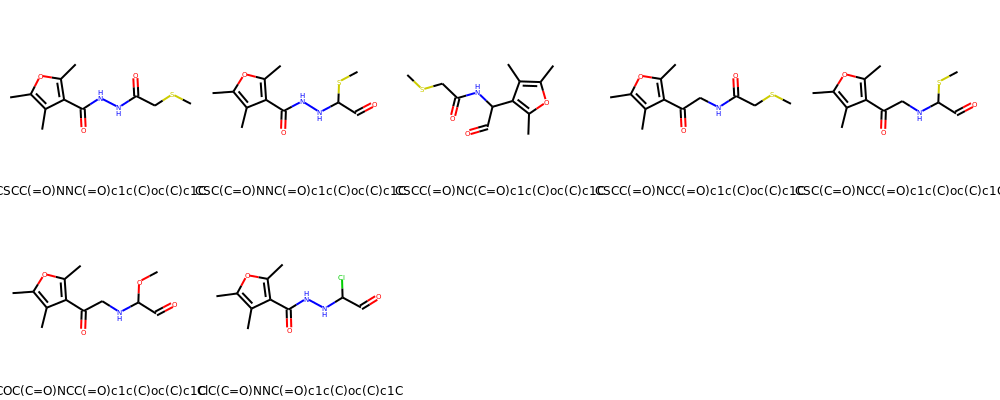

In [9]:
_ = generate_from_latent(model, zs[1])

Searching molecules randomly sampled from 5.00 std (z-distance) from the point
Found 11 unique mols, out of 79
SMILES
 0     CSCC(=O)NNC(=O)c1c(C)oc(C)c1C
1     CSC(C=O)NNC(=O)c1c(C)oc(C)c1C
2     CSCC(=O)NC(C=O)c1c(C)oc(C)c1C
3     CSCC(=O)NCC(=O)c1c(C)oc(C)c1C
4     CSC(C=O)NC(C=O)c1c(C)oc(C)c1C
5     COCC(=O)NCC(=O)c1c(C)oc(C)c1C
6     CSC(C=O)NCC(=O)c1c(C)oc(C)c1C
7     COC(C=O)NCC(=O)c1c(C)oc(C)c1C
8     CSC(C=O)NCC(=O)c1oc(C)c(C)c1C
9     ClCC(=O)NNC(=O)c1c(C)oc(C)c1C
10    ClCC(=O)NCC(=O)c1c(C)oc(C)c1C
Name: smiles, dtype: object


RDKit ERROR: [23:45:32] non-ring atom 8 marked aromatic
RDKit ERROR: [23:45:32] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [23:45:32] non-ring atom 8 marked aromatic
RDKit ERROR: [23:45:32] non-ring atom 8 marked aromatic
RDKit ERROR: [23:45:32] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [23:45:32] SMILES Parse Error: syntax error while parsing: CSC@(=O)NC(C=O)c1c(C)oc(C)c1C
RDKit ERROR: [23:45:32] SMILES Parse Error: Failed parsing SMILES 'CSC@(=O)NC(C=O)c1c(C)oc(C)c1C' for input: 'CSC@(=O)NC(C=O)c1c(C)oc(C)c1C'


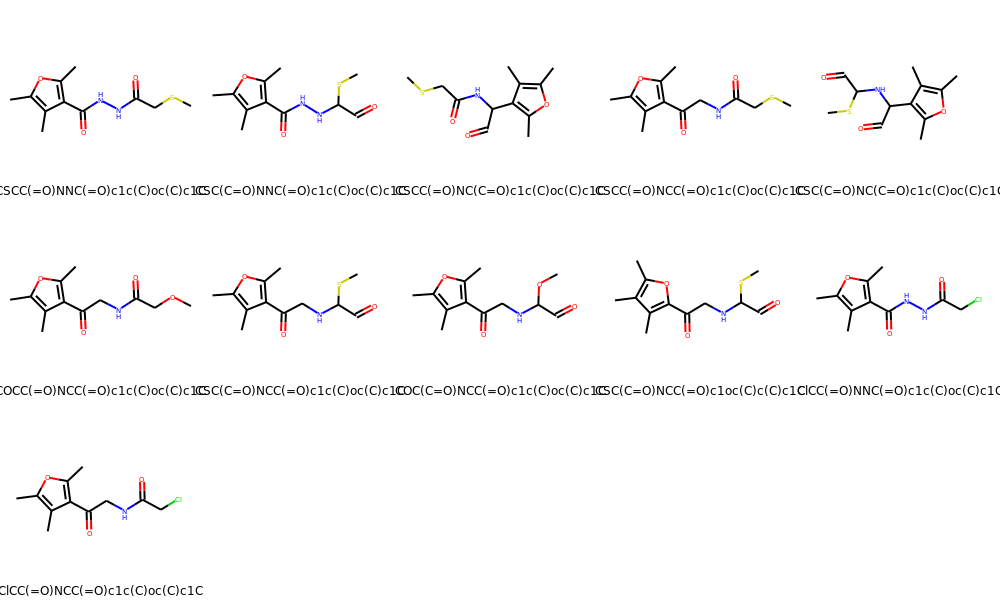

In [10]:
_ = generate_from_latent(model, zs[2])